In [140]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import os
import numpy as np
import matplotlib.pyplot as plt


#### The paths:
- data_path
- output_path
- graphviz_path

In [ ]:
data_path = "../../data/After_game_Prediction/Premier-League-2022-2023/processed"
output_path = "../../result/After_game_Prediction/Premier-League-2022-2023"
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Sample on misc_all
### Data Preperation

In [127]:
misc_all = pd.read_csv(os.path.join(data_path, "misc_all.csv"))

# Change the venue to a number
venue_dict = {
    "Home": 0,
    "Away": 1
}
Result_dict = {
    "W": 1,
    "D": 0,
    "L": -1
}

misc_all["Venue"] = misc_all["Venue"].map(venue_dict)
misc_all["Result"] = misc_all["Result"].map(Result_dict)
misc_all = misc_all.sample(frac=1).reset_index(drop=True)

train_misc_all, valid_misc_all = train_test_split(misc_all, test_size=0.2, random_state=42)

columns_to_subset_X = [
    "Venue", 'CrdY', 'CrdR', '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'Int', 'TklW', 'PKwon', 'PKcon', 'OG', 'Recov', 'Won', 'Lost', 'Won%'
]
columns_to_subset_y = [
    "Result", "GF", "GA"
]

X = train_misc_all[columns_to_subset_X]
y = train_misc_all["Result"]

X_test = valid_misc_all[columns_to_subset_X]
y_test = valid_misc_all["Result"]


In [104]:
print(y.unique())
print(misc_all["Result"].unique())

[ 0  1 -1]
[-1  1  0]


### The Decision Tree Model

In [119]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X, y)

y_model = tree_clf.predict_proba(X_test)

accuracy: 0.4407894736842105


### Performance Measure
Approach 1: accuracy

In [ ]:
correct = 0
outcomes = [-1, 0, 1]
for i in range(len(y_model)):
    most_likely_index = np.argmax(y_model[i])
    most_likely_outcome = outcomes[most_likely_index]
    if most_likely_outcome == y_test.iloc[i]:
        correct += 1
print(f"accuracy: {correct/len(y_model)}")


Approach 2: Confusion Matrix

608
Counts for -1: 103, for 0: 27, for 1: 106


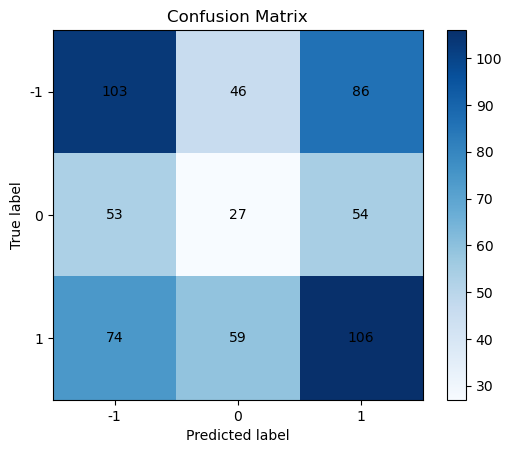

In [151]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(tree_clf, X, y, cv=3)

a = 0
b = 0
c = 0
print(len(y_train_pred))
for i in range(len(y_train_pred)):
    most_likely_outcome = y_train_pred[i]
    if most_likely_outcome == y.iloc[i]:
        if most_likely_outcome == -1:
            a += 1
        elif most_likely_outcome == 0:
            b += 1
        else:
            c += 1

print(f"Counts for -1: {a}, for 0: {b}, for 1: {c}")

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y, y_train_pred)

# Visualization
labels = ['-1', '0', '1']

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels to the plot
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# Add numerical values in each cell
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, conf_matrix[i, j], horizontalalignment='center', verticalalignment='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Approach 3: Precision, Recall and f1 Score

In [157]:
precision_score_1 = conf_matrix[2, 2] / (conf_matrix[2, 2] + conf_matrix[1, 2] + conf_matrix[0, 2])
pricision_score_0 = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1] + conf_matrix[2, 1])
pricision_score_minus_1 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0] + conf_matrix[2, 0])
print(f"Precision score for 1: {precision_score_1}, for 0: {pricision_score_0}, for -1: {pricision_score_minus_1}")

recall_score_1 = conf_matrix[2, 2] / (conf_matrix[2, 2] + conf_matrix[2, 1] + conf_matrix[2, 0])
recall_score_0 = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0] + conf_matrix[1, 2])
recall_score_minus_1 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1] + conf_matrix[0, 2])
print(f"Recall score for 1: {recall_score_1}, for 0: {recall_score_0}, for -1: {recall_score_minus_1}")

f1_score_1 = 2 * (precision_score_1 * recall_score_1) / (precision_score_1 + recall_score_1)
f1_score_0 = 2 * (pricision_score_0 * recall_score_0) / (pricision_score_0 + recall_score_0)
f1_score_minus_1 = 2 * (pricision_score_minus_1 * recall_score_minus_1) / (pricision_score_minus_1 + recall_score_minus_1)
print(f"F1 score for 1: {f1_score_1}, for 0: {f1_score_0}, for -1: {f1_score_minus_1}")


Precision score for 1: 0.43089430894308944, for 0: 0.20454545454545456, for -1: 0.44782608695652176
Recall score for 1: 0.4435146443514644, for 0: 0.20149253731343283, for -1: 0.43829787234042555
F1 score for 1: 0.43711340206185567, for 0: 0.20300751879699247, for -1: 0.4430107526881721


### Export Decision Tree Graph

In [135]:
export_graphviz(
    tree_clf,
    out_file=output_path + "/decision_tree_misc.dot",
    feature_names=columns_to_subset_X,
    class_names=np.array(["L", "D", "W"]),
    rounded=True,
    filled=True
)

import graphviz

graphviz_path = r"C:\Program Files\Graphviz\bin"
with open(os.path.join(output_path, "decision_tree_misc.dot"), "r") as dot_file:
    dot_data = dot_file.read()
graph = graphviz.Source(dot_data)
graph.render("decision_tree_misc", format="png", cleanup=True)

graph.view()


'decision_tree_misc.pdf'

# Apply Random Forest Model to all.csv
### Data Preperation

In [291]:
df_all = pd.read_csv(os.path.join(folder_path, "all.csv"))
# for i in range(len(os.listdir(folder_path))):
#     df = pd.read_csv(os.path.join(folder_path, os.listdir(folder_path)[i]))
#     print(f"folder: {os.listdir(folder_path)[i]}")
#     print(df.columns)
    
columns_to_subset_X = [
    'Venue', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Tkl.1', 'Att', 'Tkl%', 'Lost', 'Blocks', 'Sh', 'Pass', 'Int', 'Tkl+Int', 'Clr', 'Err', 'SCA', 'TO', 'Sh', 'Fld', 'Def', 'TO.1', 'Sh.1', 'Fld.1', 'Def.1', 'SoTA', 'Saves', 'PKatt', 'PKA', 'PKsv', 'PKm', 'Cmp', 'Att', 'Cmp%', 'Att (GK)', 'Thr', 'Launch%', 'AvgLen', 'Att.1', 'Launch%.1', 'AvgLen.1', 'Opp', 'Stp', 'Stp%', '#OPA', 'AvgDist', 'CrdY', 'CrdR', '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'Int', 'TklW', 'PKwon', 'PKcon', 'OG', 'Recov', 'Won', 'Lost', 'Won%', 'Cmp', 'Att', 'Cmp%', 'TotDist', 'PrgDist', 'Cmp.1', 'Att.1', 'Cmp%.1', 'Cmp.2', 'Att.2', 'Cmp%.2', 'Cmp.3', 'Att.3', 'Cmp%.3', 'xA', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP', 'Att', 'Live', 'Dead', 'FK', 'TB', 'Sw', 'Crs', 'TI', 'CK', 'In', 'Out', 'Str', 'Cmp', 'Off', 'Blocks', 'Poss', 'Touches', 'Def Pen', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen', 'Live', 'Att', 'Succ', 'Succ%', 'Tkld', 'Tkld%', 'Carries', 'TotDist', 'PrgDist', 'PrgC', '1/3', 'CPA', 'Mis', 'Dis', 'Rec', 'PrgR', 'Dist', 'FK', 'PK', 'PKatt'
]

# Removed: Gls, gca, GA, G/SoT, G/sh, CS, Save%, Ast, PassLive, PassLive.1, np:G-xG，G-xG, npxG/Sh, 'xG', 'npxG', 'PSxG', 'PSxG+/-', 'xAG', 'PassDead', 'PassDead.1', 'Sh', 'SoT', 'SoT%', 

columns_to_subset_X = list(set(columns_to_subset_X))

venue_dict = {
    "Home": 0,
    "Away": 1
}

Result_dict = {
    "W": 1,
    "D": 0,
    "L": -1
}

df_all.dropna(subset=columns_to_subset_X, inplace=True)
# Cleanup duplicate columns
df_all = df_all.loc[:, ~df_all.columns.duplicated()]
df_all["Venue"] = df_all["Venue"].map(venue_dict)
df_all["Result"] = df_all["Result"].map(Result_dict)

train_all, valid_all = train_test_split(df_all, test_size=0.2, random_state=42)

X = train_all[columns_to_subset_X]
y = train_all["Result"]

X_test = valid_all[columns_to_subset_X]
y_test = valid_all["Result"]

### Modeling
#### Randome Forest & Decision Tree

In [292]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X, y)

tree_clf_all = DecisionTreeClassifier(max_depth=7)
tree_clf_all.fit(X, y)

DecisionTreeClassifier(max_depth=7)

### Performance Measure
Approach 1: accuracy

In [293]:
y_pred_rf = rf.predict(X_test)
correct = 0
outcomes = [-1, 0, 1]
for i in range(len(y_pred_rf)):
    most_likely_outcome = y_pred_rf[i]
    if most_likely_outcome == y_test.iloc[i]:
        correct += 1
print(f"accuracy: {correct/len(y_pred_rf)}")


y_pred_dt = tree_clf_all.predict(X_test)
correct = 0
outcomes = [-1, 0, 1]
for i in range(len(y_pred_dt)):
    most_likely_outcome = y_pred_dt[i]
    if most_likely_outcome == y_test.iloc[i]:
        correct += 1
print(f"accuracy: {correct/len(y_pred_dt)}")

accuracy: 0.6153846153846154
accuracy: 0.3916083916083916


Approach 2: Confusion Matrix

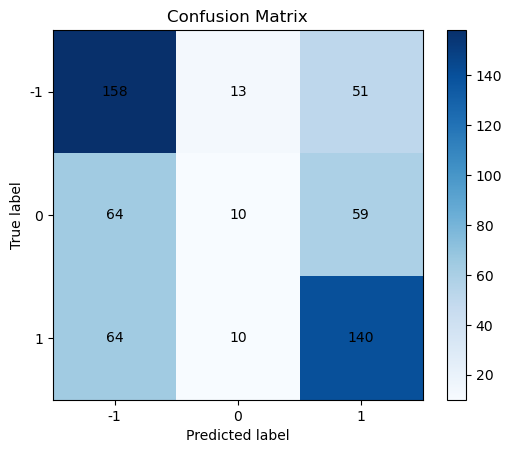

In [294]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(rf, X, y, cv=3)

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y, y_train_pred)

# Visualization
labels = ['-1', '0', '1']

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels to the plot
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# Add numerical values in each cell
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, conf_matrix[i, j], horizontalalignment='center', verticalalignment='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

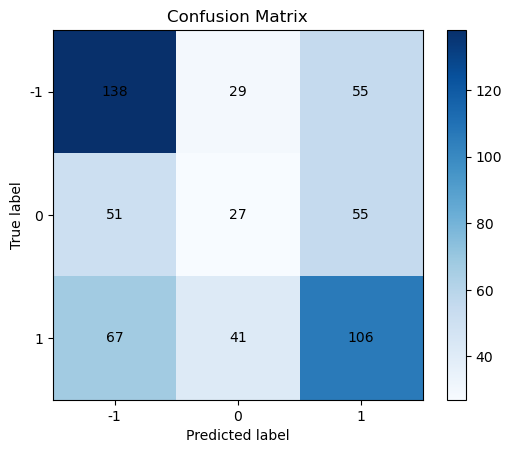

In [290]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(tree_clf_all, X, y, cv=3)

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y, y_train_pred)

# Visualization
labels = ['-1', '0', '1']

plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels to the plot
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# Add numerical values in each cell
for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, conf_matrix[i, j], horizontalalignment='center', verticalalignment='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### Graph Export (Decision Tree)

In [289]:
export_graphviz(
    tree_clf_all,
    out_file=output_path + "/decision_tree_all.dot",
    feature_names=columns_to_subset_X,
    class_names=np.array(["L", "D", "W"]),
    rounded=True,
    filled=True
)

import graphviz

graphviz_path = r"C:\Program Files\Graphviz\bin"
with open(os.path.join(output_path, "decision_tree_all.dot"), "r") as dot_file:
    dot_data = dot_file.read()
graph = graphviz.Source(dot_data)

graph.render(os.path.join(output_path, "decision_tree_all"), format="png", cleanup=True)

graph.view()

'..\\..\\result\\After_game_Prediction\\Premier-League-2022-2023\\decision_tree_all.pdf'